This encompasses the approach to text processing with a more OCR approach.
1. Gray-scale ->  Blur image -> draw ROI of blurred dark area -> Retrieve ROI as Rect -> Extract text using Rect with PyMuPDF
2. Possible drawback:
- Inability to detect text in 

In [1]:
import pymupdf
import cv2
import json
import collections

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import heapq
class MedianFinder(object):
    def __init__(self):
        self.minheap = []
        self.maxheap = []

    def addNum(self, num:float):
        if not self.minheap and not self.maxheap:
            heapq.heappush(self.maxheap, -num)
        else:
            if len(self.minheap)== len(self.maxheap):
                if -self.maxheap[0]<=num:
                    heapq.heappush(self.minheap, num)
                    heapq.heappush(self.maxheap, -heapq.heappop(self.minheap))
                else:
                    heapq.heappush(self.maxheap, -num)
            else:
                if -self.maxheap[0]<= num:
                    heapq.heappush(self.minheap, num)
                else:
                    heapq.heappush(self.minheap, -heapq.heappop(self.maxheap))
                    heapq.heappush(self.maxheap, -num)
                
    def findMedian(self):
        if len(self.minheap)==len(self.maxheap):
            return (self.minheap[0]-self.maxheap[0])/2.0
        else:
            return -self.maxheap[0]

In [4]:

class Node:
    def __init__(self, content):
        self.content = content
        self.children = []
    def add_child(self, child):
        self.children.append(child)
    def __str__(self):
        return f"Node({self.content}, {self.children})"

In [5]:
def should_merge(
    rect1: pymupdf.Rect,
    rect2: pymupdf.Rect,
    h_threshold: float = 8,
    v_threshold: float = 1,
    min_h_overlap_factor: float = 0.75
) -> bool:
    """
    Determine if two rectangles should be merged based on proximity or overlap.

    Args:
        rect1, rect2: PyMuPDF Rect objects to compare.
        h_threshold: Maximum horizontal gap allowed for merging adjacent rectangles
                     on the same line.
        v_threshold: Maximum vertical gap allowed for merging rectangles that
                     have significant horizontal overlap.
        same_line_height_factor: Multiplier for average height to determine if
                                 rectangles are on the same line (based on y0 diff).
        min_h_overlap_factor: Minimum horizontal overlap (as a fraction of the *smaller* width) required to consider vertical merging.

    Returns:
        bool: True if rectangles should be merged, False otherwise.
    """
    # --- Basic Properties and Checks ---
    if not rect1 or not rect2 or rect1.is_empty or rect2.is_empty:
        return False # Cannot merge with invalid or empty rectangles

    height1 = rect1.height
    height2 = rect2.height
    # Avoid division by zero if heights are zero
    avg_height = (height1 + height2) / 2.0 if (height1 + height2) > 0 else 0

    # --- Condition 1: Horizontal Proximity on Same Line ---
    # Check if vertically aligned enough to be on the same 'line'
    # Use y-centers for potentially better alignment check than just y0
    # is_same_line = abs(rect1.y0 - rect2.y0) < avg_height * same_line_height_factor
    y_center1 = rect1.y0 + height1 / 2.0
    y_center2 = rect2.y0 + height2 / 2.0
    # Rects are on same line if vertical distance between centers is less than avg height
    is_same_line = abs(y_center1 - y_center2) < avg_height if avg_height > 0 else (rect1.y0 == rect2.y0)


    # Calculate horizontal gap (only if they don't overlap horizontally)
    h_gap = -1.0
    if rect1.x1 <= rect2.x0: # rect1 is left of rect2
        h_gap = rect2.x0 - rect1.x1
    elif rect2.x1 <= rect1.x0: # rect2 is left of rect1
        h_gap = rect1.x0 - rect2.x1

    if is_same_line and h_gap >= 0 and h_gap < h_threshold:
        # print(f"H-Merge: {rect1} & {rect2} (gap {h_gap:.2f})") # Debug
        return True # Merge if close horizontally on the same line

    # --- Condition 2: Vertical Proximity with Significant Horizontal Overlap ---
    # Calculate horizontal overlap width
    h_overlap_width = max(0.0, min(rect1.x1, rect2.x1) - max(rect1.x0, rect2.x0))

    # Check if horizontal overlap is significant
    min_width = min(rect1.width, rect2.width)
    has_significant_h_overlap = False
    if min_width > 0 and h_overlap_width / min_width >= min_h_overlap_factor:
        has_significant_h_overlap = True
    elif h_overlap_width > 0 and min_width <= 0: # Overlap exists, one rect has no width? Consider overlap significant.
        has_significant_h_overlap = True
    # Alternative check: One rect is contained horizontally within the other
    is_contained_horizontally = (rect1.x0 >= rect2.x0 and rect1.x1 <= rect2.x1) or \
                                (rect2.x0 >= rect1.x0 and rect2.x1 <= rect1.x1)

    if has_significant_h_overlap or is_contained_horizontally:
        # Calculate vertical gap (only if they don't overlap vertically)
        v_gap = -1.0
        if rect1.y1 <= rect2.y0: # rect1 is above rect2
            v_gap = rect2.y0 - rect1.y1
        elif rect2.y1 <= rect1.y0: # rect2 is above rect1
            v_gap = rect1.y0 - rect2.y1

        if v_gap >= 0 and v_gap < v_threshold:
            # print(f"V-Merge: {rect1} & {rect2} (gap {v_gap:.2f})") # Debug
            return True # Merge if close vertically and overlap significantly horizontally

    # --- Condition 3: Direct Overlap (Optional but good fallback) ---
    # Check if rectangles intersect (overlap) significantly in both dimensions?
    # The previous checks cover proximity *near* overlap.
    # If they actually overlap, should they always merge? Often yes.
    # Calculate vertical overlap
    v_overlap_height = max(0.0, min(rect1.y1, rect2.y1) - max(rect1.y0, rect2.y0))

    # If they overlap both horizontally and vertically, merge them.
    if h_overlap_width > 0 and v_overlap_height > 0:
        # print(f"O-Merge: {rect1} & {rect2}") # Debug
        return True

    return False # No merge conditions met
def merge_text_regions(regions, iterations=3):
    """
    Merge text regions that are close to each other.
    
    Args:
        regions: List of PyMuPDF Rect objects
        iterations: Number of merging passes to perform
    Returns:
        list: Merged PyMuPDF Rect objects
    """
    if not regions:
        return []
    
    # Perform multiple iterations of merging to handle chains of regions
    for _ in range(iterations):
        merged = False
        i = 0
        while i < len(regions):
            j = i + 1
            while j < len(regions):
                if should_merge(regions[i], regions[j], h_threshold=6, v_threshold=1): # Make this more relative
                    # Merge rectangles
                    merged_rect = pymupdf.Rect(
                        min(regions[i].x0, regions[j].x0),
                        min(regions[i].y0, regions[j].y0),
                        max(regions[i].x1, regions[j].x1),
                        max(regions[i].y1, regions[j].y1)
                    )
                    regions[i] = merged_rect
                    regions.pop(j)
                    merged = True
                else:
                    j += 1
            i += 1
            
        if not merged:
            break
            
    return regions

In [6]:
from typing import Dict, Any, List
def extract_page_text_via_image_regions(
    page: pymupdf.Page,
    zoom_factor: int = 2,
    adaptive_thresh_block_size: int = 13, # Must be odd > 1
    adaptive_thresh_c: int = 2,
    morph_kernel_size: tuple = (8, 8),
    dilate_iterations: int = 1,
    canny_thresh1: int = 50,
    canny_thresh2: int = 200,
    min_region_width: float = 8.0, # In PDF points
    min_region_height: float = 8.0, # In PDF points
    merge_iterations: int = 6,
    region_padding: float = 0.3, # Padding around merged regions for word capture (PDF points)
    line_break_threshold: float = 0.6, # Factor of word height to detect line breaks
    filter_numeric_blocks: bool = True, # Skip blocks containing only digits
    handle_unassigned_words: bool = False, # Option to process words not in any region
    visual_proof: bool = False
) -> List[Dict[str, Any]]:
    """
    Extracts text from a PDF page by detecting text regions using OpenCV
    on a rendered image, merging regions, and then extracting PyMuPDF text
    within those regions.
    Args:
        page: The pymupdf.Page object to process.
        zoom_factor: Factor to render the page image (higher zoom = more detail, slower).
        adaptive_thresh_block_size: Block size for OpenCV adaptive thresholding.
        adaptive_thresh_c: Constant subtracted in adaptive thresholding.
        morph_kernel_size: Kernel size for morphological operations (dilation, closing).
        dilate_iterations: Number of iterations for dilation.
        canny_thresh1: Lower threshold for Canny edge detection.
        canny_thresh2: Upper threshold for Canny edge detection.
        min_region_width: Minimum width of a valid detected region (in PDF points).
        min_region_height: Minimum height of a valid detected region (in PDF points).
        merge_iterations: Iterations for the (abstracted) merge_text_regions function.
        region_padding: Padding added around merged regions before capturing words.
        line_break_threshold: Factor of word height used in heuristic line break detection.
        filter_numeric_blocks: If True, blocks containing only digits are discarded.
        handle_unassigned_words: If True, attempt to process words not captured (NYI).
        visual_proof: If True, display intermediate processing images using matplotlib.
    Returns:
        A list of dictionaries, where each dictionary represents a detected
        text block and contains:
        - "occupy_space": The pymupdf.Rect of the merged region.
        - "content": The extracted text content (str).
        - "text_height_median": The median height of words in the block (float).
        - "min_height": The minimum height of words in the block (float).
        - "page_num": The page number (0-indexed).
    """
    print(f"Processing Page {page.number} via Image Regions...")
    # 1. Render Page to Image
    try:
        mat = pymupdf.Matrix(zoom_factor, zoom_factor)
        pix = page.get_pixmap(matrix=mat)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.h, pix.w, pix.n)
    except Exception as e:
        print(f"  Error rendering page {page.number} to pixmap: {e}")
        return []
    # 2. OpenCV Image Processing to Find Contours
    # Ensure image is grayscale (single channel) before thresholding
    if len(img.shape) == 3 and img.shape[2] >= 3: # Check if color channels exist
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif len(img.shape) == 3 and img.shape[2] == 1: # Single channel but 3D array
         gray = img[:, :, 0]
    elif len(img.shape) == 2: # Already grayscale
         gray = img
    else: # Handle unexpected image format
         print(f"  Error: Cannot convert image with shape {img.shape} to grayscale.")
         return []
    # Apply adaptive thresholding to get a binary (black and white) image
    # THRESH_BINARY_INV makes text white and background black
    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, adaptive_thresh_block_size, adaptive_thresh_c)
    # Morphological operations to connect characters/words into text block shapes
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_size)
    # Dilate to make text regions larger and connect nearby components
    dilated = cv2.dilate(adaptive, rectKernel, iterations=dilate_iterations)
    # Closing to fill small gaps within text regions
    closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel)
    # Canny edge detection (sometimes helps refine contours, applied on the closed image)
    edged = cv2.Canny(closing, canny_thresh1, canny_thresh2, apertureSize=3)
    # Find external contours on the edge map
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"  Found {len(contours)} initial contours.")
    # 3. Create Initial Regions from Contours
    initial_regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Convert back to PDF coordinates
        pdf_x0, pdf_y0 = x / zoom_factor, y / zoom_factor
        pdf_x1, pdf_y1 = (x + w) / zoom_factor, (y + h) / zoom_factor
        rect = pymupdf.Rect(pdf_x0, pdf_y0, pdf_x1, pdf_y1)
        # Pre-filter small contours (looser threshold before merging)
        if rect.width >= min_region_width / 2 and rect.height >= min_region_height / 2:
             initial_regions.append(rect)
    print(f"  Created {len(initial_regions)} initial regions after pre-filtering.")
    # 4. Merge Overlapping/Nearby Regions (Abstracted Call)
    merged_regions = merge_text_regions(initial_regions, iterations=merge_iterations)
    # Filter out regions that are too small after merging
    final_regions = [r for r in merged_regions
                     if r.width >= min_region_width and r.height >= min_region_height]
    print(f"  {len(final_regions)} regions remaining after merging and size filtering.")
    # Sort final regions by reading order (top-to-bottom, left-to-right)
    final_regions.sort(key=lambda r: (r.y0, r.x0))
    
    words_data = page.get_text("words")
    if not words_data:
        print(f"  No text words found on page {page.number} by PyMuPDF.")
        print("Trying OCR fallback...")
        words_data = page.get_textpage_ocr("words")
    if not words_data:
        return []
    # Prepare word items with rectangles and assignment status
    word_items = [{
        "rect": pymupdf.Rect(w[:4]),
        "text": w[4],
        "baseline": w[1], # Using y0 of word bbox as approx baseline
        "height": pymupdf.Rect(w[:4]).height,
        "assigned": False
    } for w in words_data]
    # 6. Assign Words to Regions and Reconstruct Text Blocks
    extracted_blocks = []
    for region_rect in final_regions:
        # Define the padded capture area for the current region
        padded_rect = pymupdf.Rect(region_rect.x0 - region_padding,
                                   region_rect.y0 - region_padding,
                                   region_rect.x1 + region_padding,
                                   region_rect.y1 + region_padding)
        words_in_region_indices = []
        median_finder = MedianFinder()
        # Find unassigned words that intersect the padded region
        for idx, item in enumerate(word_items):
            if not item["assigned"] and item["rect"].intersects(padded_rect):
                words_in_region_indices.append(idx)
                if item["height"] > 0: # Only add valid heights
                    median_finder.addNum(item["height"])
                item["assigned"] = True
        if not words_in_region_indices:
            continue # Skip region if no words are found within it
        # Sort words within the region by reading order
        current_block_words = [word_items[i] for i in words_in_region_indices]
        current_block_words.sort(key=lambda w: (w["rect"].y0, w["rect"].x0))
        block_text = ""
        min_height_in_block = float('inf')
        prev_baseline = current_block_words[0]["baseline"] if current_block_words else 0
        prev_rect = current_block_words[0]["rect"] if current_block_words else None

        for word_item in current_block_words:
            current_rect = word_item["rect"]
            current_baseline = word_item["baseline"]
            current_height = word_item["height"]

            if current_height > 0:
                 min_height_in_block = min(min_height_in_block, current_height)

            # Heuristic for line breaks:
            # Check vertical distance between baselines relative to current word height.
            # Also consider horizontal gap for same-line detection.
            vertical_distance = abs(prev_baseline - current_baseline)
            # Estimate horizontal gap (if rects don't overlap horizontally)
            h_gap = -1
            if prev_rect and current_rect.x0 >= prev_rect.x1:
                h_gap = current_rect.x0 - prev_rect.x1

            # Primarily rely on vertical distance for line break detection
            # A small vertical distance suggests same line.
            # Use a threshold relative to text height.
            is_same_line = vertical_distance < (current_height * line_break_threshold) if current_height > 0 else (vertical_distance < 2) # Fallback for zero height

            separator = " " if is_same_line else "\n"
            if block_text: # Add separator only if text already exists
                block_text += separator
            block_text += word_item["text"]

            prev_baseline = current_baseline
            prev_rect = current_rect

        content = block_text.strip()
        if not content: continue
        if filter_numeric_blocks and content.isdigit():
            print(f"  Skipping numeric block: '{content}'")
            continue
        # Store the extracted block information
        extracted_blocks.append({
            "occupy_space": region_rect,
            "content": content,
            "text_height_median": median_finder.findMedian() if (median_finder.minheap or median_finder.maxheap) else 0, 
            "min_height": min_height_in_block if min_height_in_block != float('inf') else 0,
            "page_num": page.number
        })
    print(f"  Extracted {len(extracted_blocks)} text blocks.")
    # 7.  Handle Unassigned Words (Optional)
    unassigned_word_count = sum(1 for item in word_items if not item["assigned"])
    if unassigned_word_count > 0:
        print(f"  Warning: {unassigned_word_count} words were not assigned to any detected region.")
        if handle_unassigned_words:
            print("  (Handling unassigned words not implemented)")
            # --- Add logic here to potentially group/process unassigned words ---
            pass
        # --- End NYI section ---
    # 8. Visual Proof (Optional)
    if visual_proof:
        try:
            viz_img = img.copy() # Use the original image for visualization
            # Draw final merged regions used for text extraction
            for item in extracted_blocks:
                rect = item["occupy_space"]
                # Convert PDF rect back to image coordinates for drawing
                x0, y0 = int(rect.x0 * zoom_factor), int(rect.y0 * zoom_factor)
                x1, y1 = int(rect.x1 * zoom_factor), int(rect.y1 * zoom_factor)
                cv2.rectangle(viz_img, (x0, y0), (x1, y1), (0, 255, 0), 2) # Green boxes
            plt.figure(figsize=(15, 15))
            # Show edge/contour image (derived from binary image)
            plt.subplot(1, 2, 1)
            plt.imshow(edged, cmap='gray')
            plt.title(f"Page {page.number} - Edges from Binary")
            plt.axis('off')
            # Show original image with detected regions overlaid
            plt.subplot(1, 2, 2)
            # Convert viz_img from BGR (OpenCV default) to RGB (matplotlib default) if necessary
            if len(viz_img.shape) == 3 and viz_img.shape[2] == 3:
                viz_img_rgb = cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB)
                plt.imshow(viz_img_rgb)
            else: # Grayscale or other
                 plt.imshow(viz_img, cmap='gray')
            plt.title(f"Page {page.number} - Detected Text Regions ({len(extracted_blocks)} blocks)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"  Error generating visual proof: {e}")
    return extracted_blocks

In [7]:
def extract_text(pdf_path:str)-> tuple[List[dict], str]:
    """PyMuPDF-based function to extract text with bounding boxes from a PDF file."""
    try:
        doc = pymupdf.open(pdf_path, filetype="pdf")
        prev_block = None
        all_blocks = []
        for page_num, page in enumerate(doc):
            words = page.get_text("words")
            page_block = []
            # Take threshold based on page_width and page_height
            WIDTH_threshold = (0.02 if page.rect.width > page.rect.height else 0.0092625) * page.rect.width
            HEIGHT_threshold = (0.01 if page.rect.width > page.rect.height else 0.05) * page.rect.height
            for curr_word in words:
                # Each block is (x0, y0, x1, y1, text, block_no, block_type)
                x0, y0, x1, y1, text, block_no, line_no, block_type = curr_word
                text_height = y1 - y0
                if not text.strip():
                    continue
                is_mergable = False
                
                """
                Check if the current block is close to the previous block.
                The conditions are:
                (1. The x-coordinates of the current block are within WIDTH_threshold of the previous block.
                2. The y-coordinates of the current block are within HEIGHT_threshold of the previous block.
                (3. The current block is not completely to the left of the previous block.
                4. The y-coordinates of the current block are within 4 pixels of the previous block.
                5. The current block is not completely to the right of the previous block.
                """
                if prev_block and abs(text_height - prev_block[-1]) <= 0 and \
                    (\
                        (abs(x0 - prev_block[2]) <= WIDTH_threshold and (y0 -prev_block[3]) <= HEIGHT_threshold) \
                    ):
                    prev_block[2] = max(prev_block[2], x1) 
                    prev_block[3] = max(prev_block[3], y1) 
                    prev_block[4] += " " + text.strip()
                    is_mergable = True

                if is_mergable and page_block:
                    page_block.pop()
                    page_block.append(
                        {
                            "page": page_num,
                            "bbox": (prev_block[0], prev_block[1], prev_block[2], prev_block[3]),
                            "text": prev_block[4],
                            "block_no": block_no,
                            "block_type": block_type,
                            "text_height": prev_block[-1]
                        }
                    )    
                    prev_block = [prev_block[0], prev_block[1], prev_block[2], prev_block[3], prev_block[4], block_no, block_type, prev_block[-1]]
                else:
                    page_block.append({
                        "page": page_num,
                        "bbox": (x0, y0, x1, y1),
                        "text": text.strip(),
                        "block_no": block_no,
                        "block_type": block_type,
                        "text_height": text_height
                    })
                    # Update the previous block
                    prev_block = [x0, y0, x1, y1, text.strip(), block_no, block_type, text_height]
            # merged_blocks = process_text_blocks(page_block, eps=25, min_samples=1)
            all_blocks.extend(page_block)
        doc.close()
        # Remove empty blocks
        if not all_blocks:
            raise Exception("PyMuPDF Failed or No text found in the PDF.")
        return (all_blocks, 'pyMuPDF')
    except Exception as e:
        print("The Error is", e.with_traceback())
        # return extract_text_with_Mistral_OCR(pdf_path)




--- Starting processing for: D:\DATA300\AudioBookSum\pdf\other\2303.00747v2.pdf ---
Processing 6 pages from 2303.00747v2.pdf...
Processing Page 0 via Image Regions...
  Found 16 initial contours.
  Created 16 initial regions after pre-filtering.
  15 regions remaining after merging and size filtering.
  Extracted 15 text blocks.


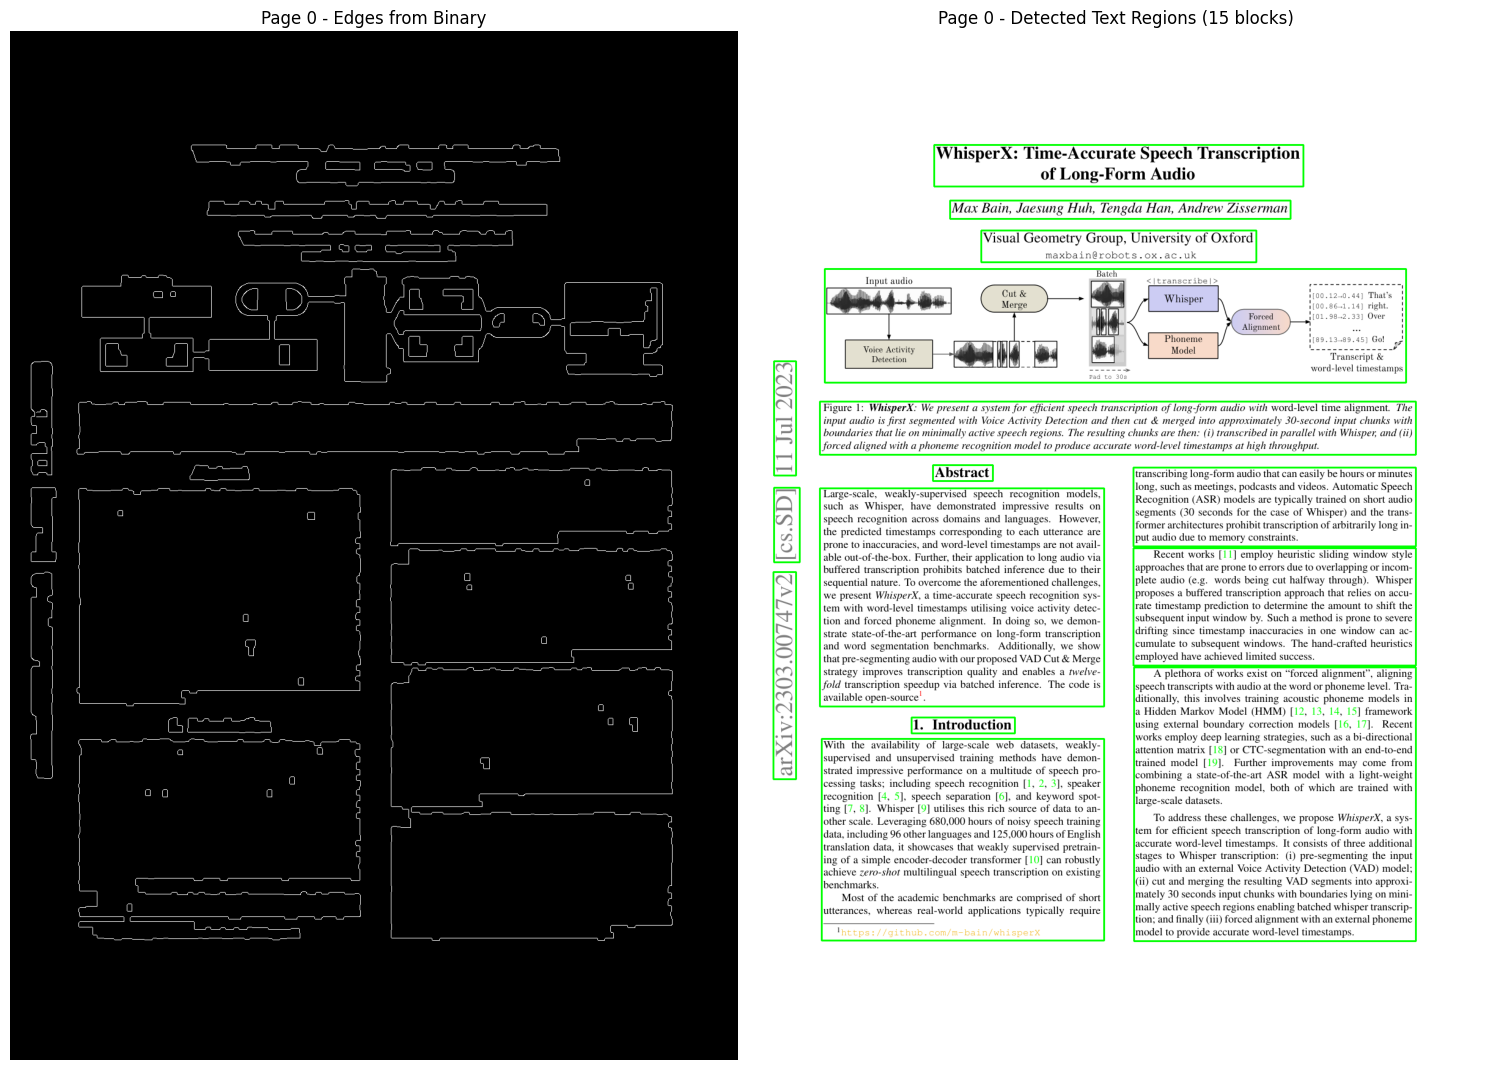

Processing Page 1 via Image Regions...
  Found 14 initial contours.
  Created 14 initial regions after pre-filtering.
  13 regions remaining after merging and size filtering.
  Extracted 13 text blocks.


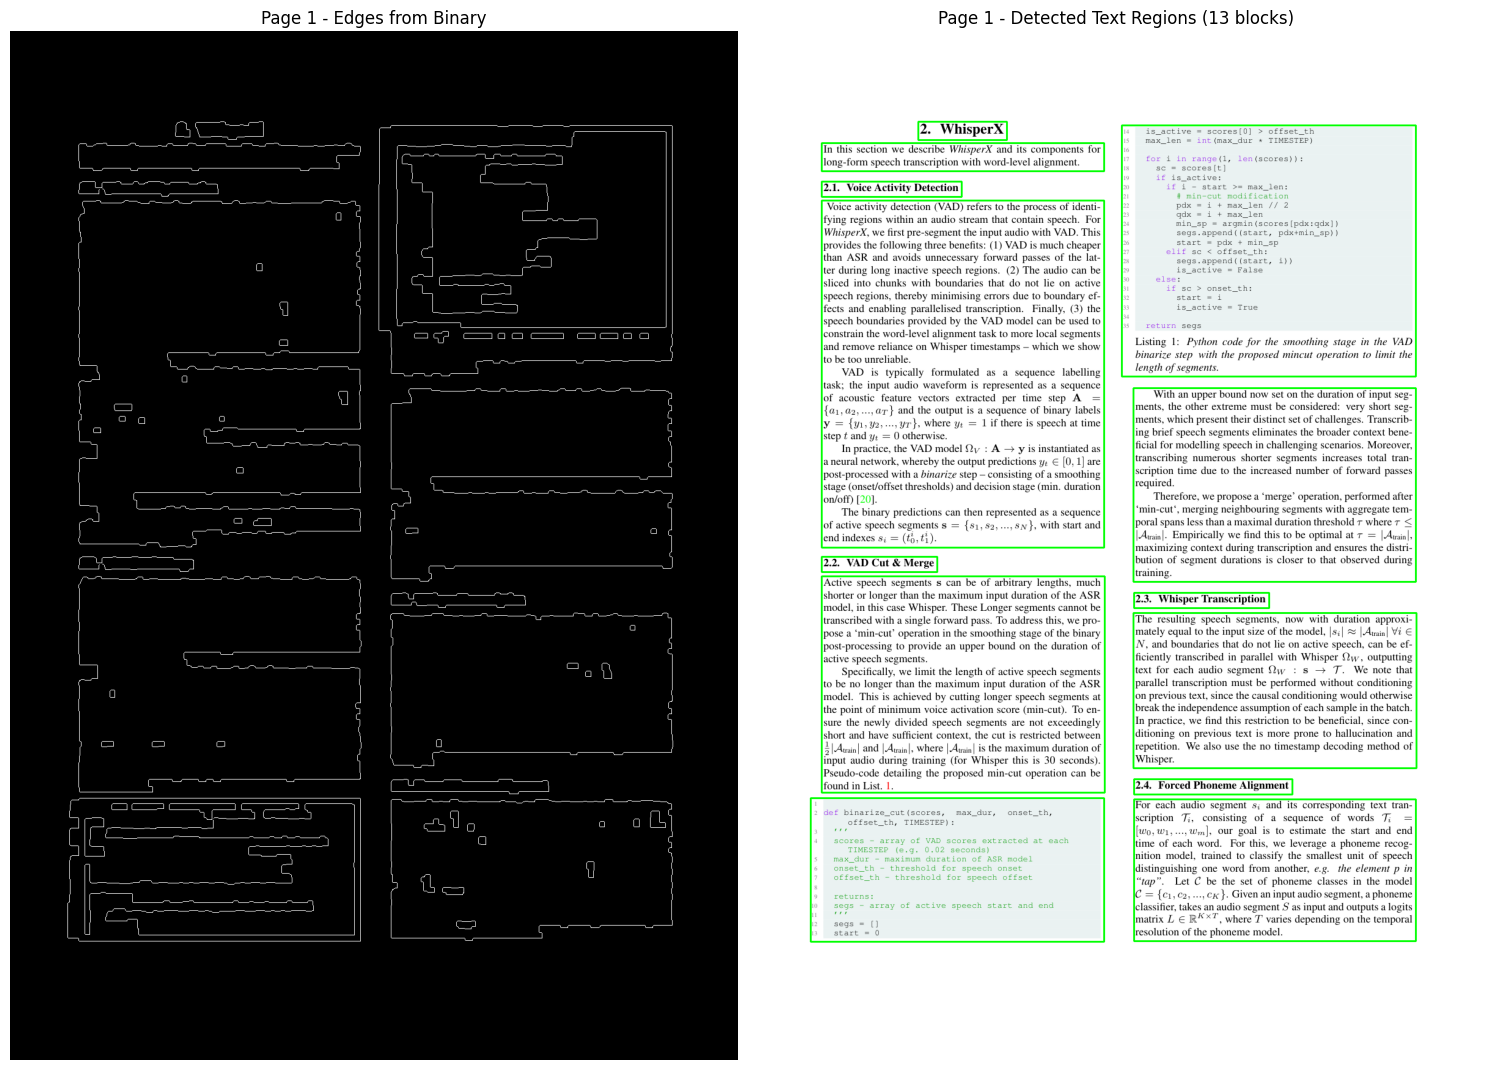

Processing Page 2 via Image Regions...
  Found 24 initial contours.
  Created 24 initial regions after pre-filtering.
  20 regions remaining after merging and size filtering.
  Extracted 20 text blocks.


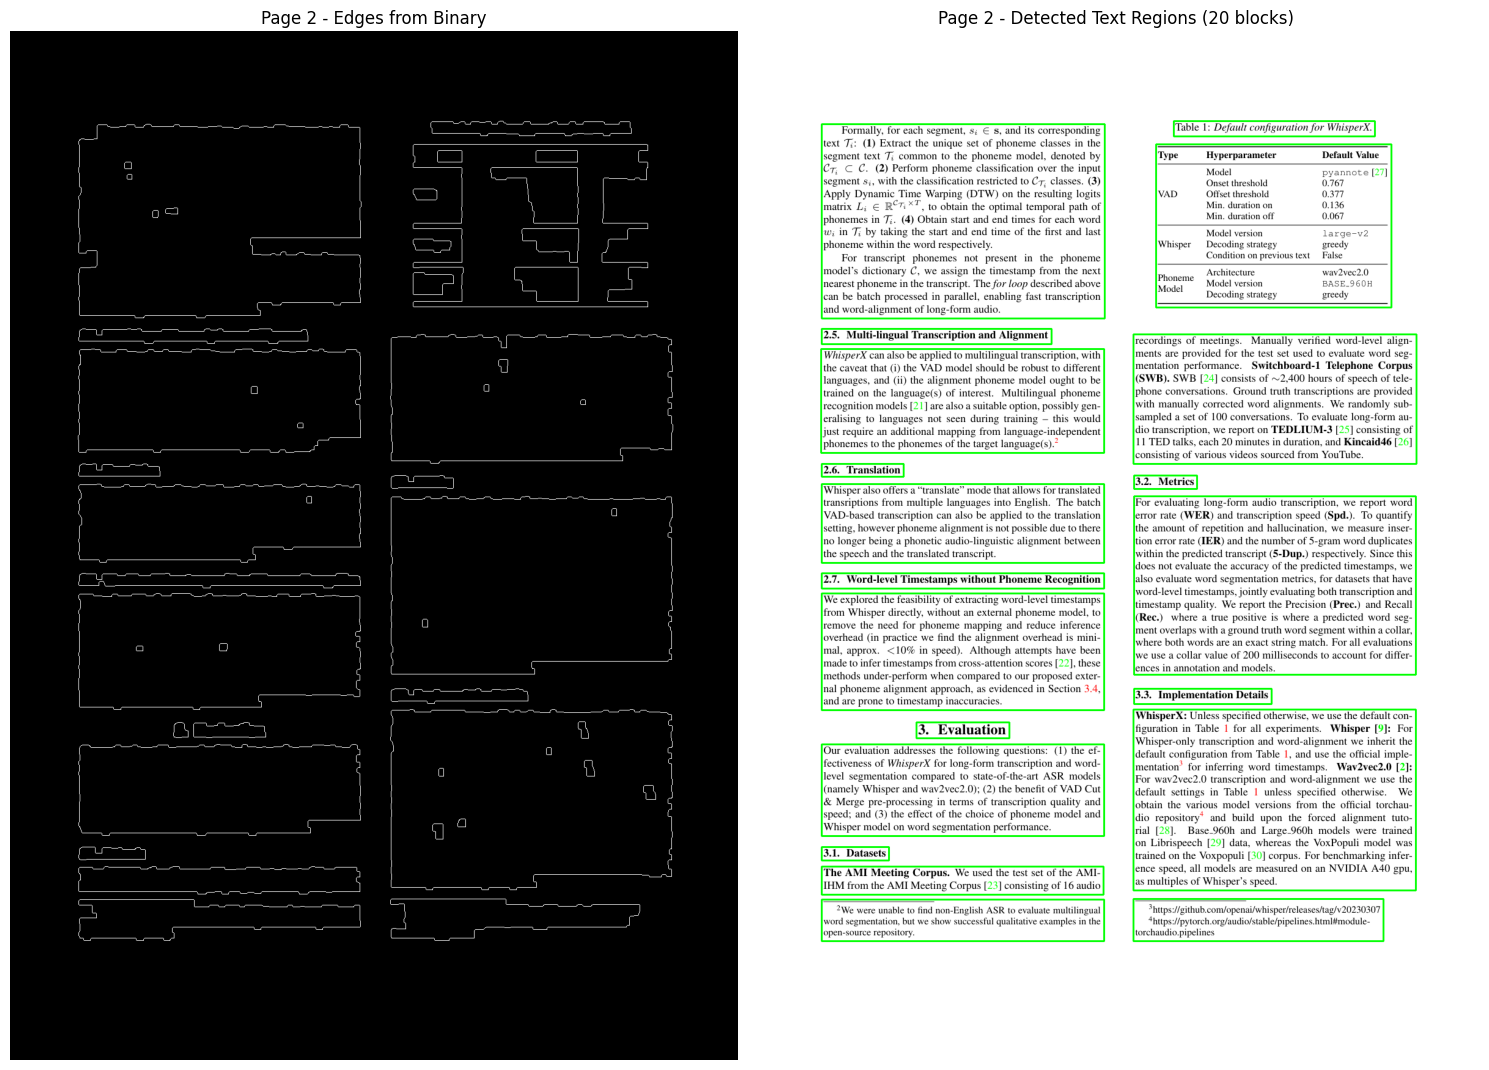

Processing Page 3 via Image Regions...
  Found 28 initial contours.
  Created 28 initial regions after pre-filtering.
  17 regions remaining after merging and size filtering.
  Extracted 17 text blocks.


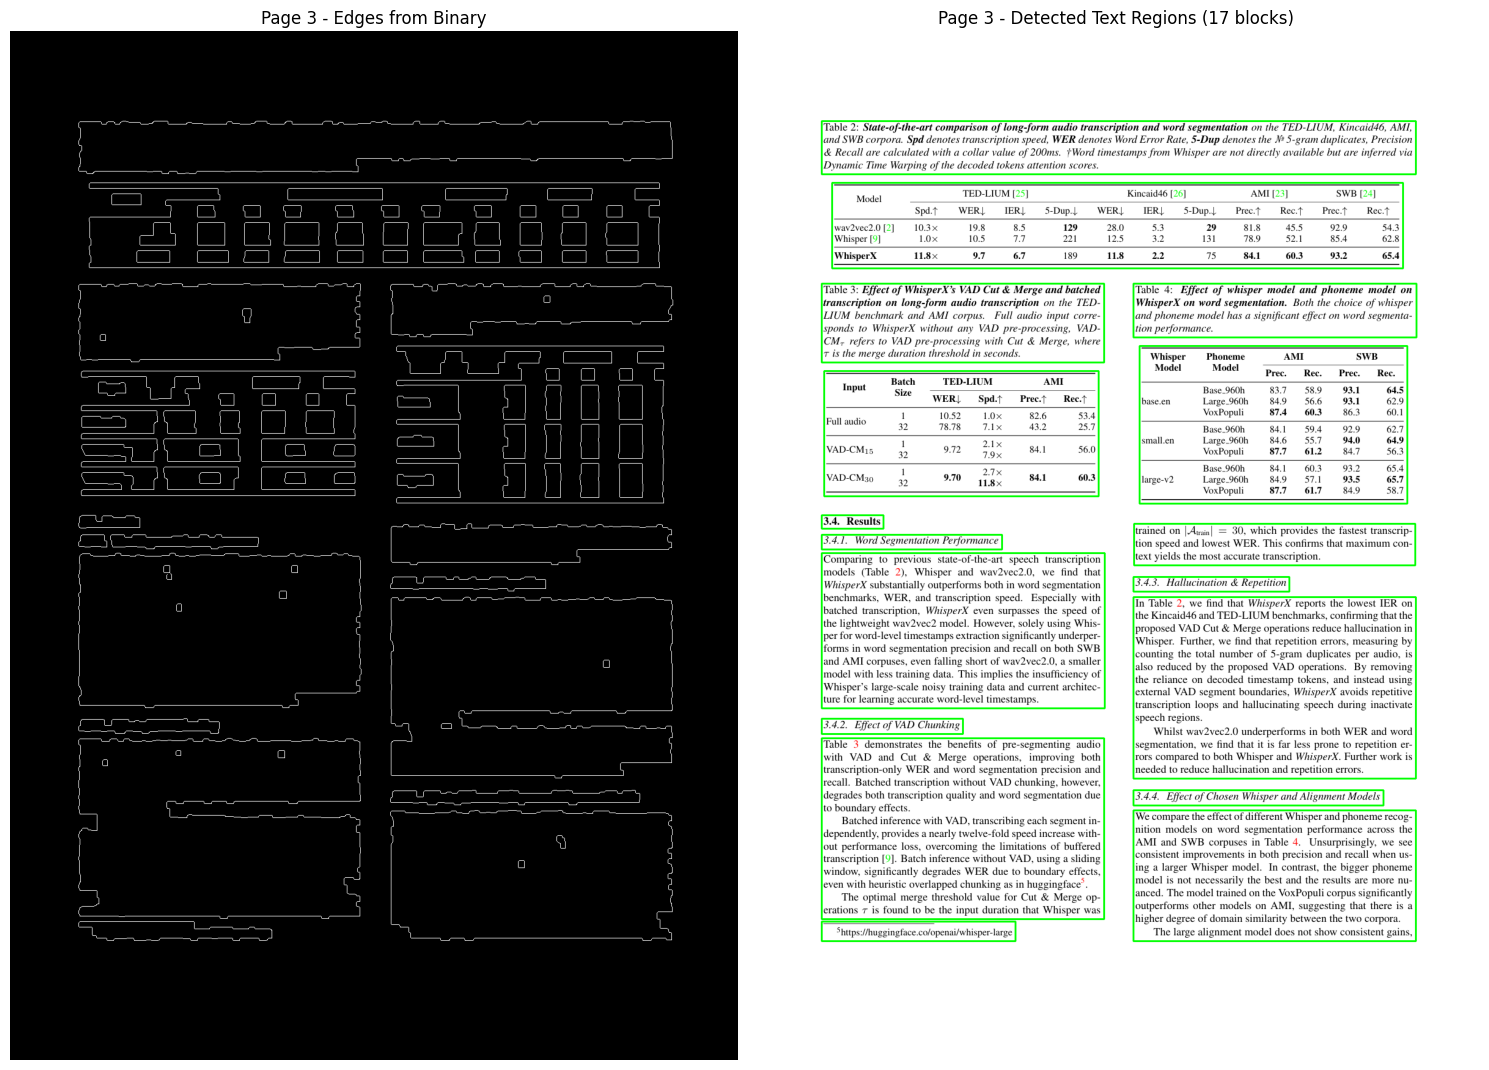

Processing Page 4 via Image Regions...
  Found 79 initial contours.
  Created 79 initial regions after pre-filtering.
  8 regions remaining after merging and size filtering.
  Extracted 8 text blocks.


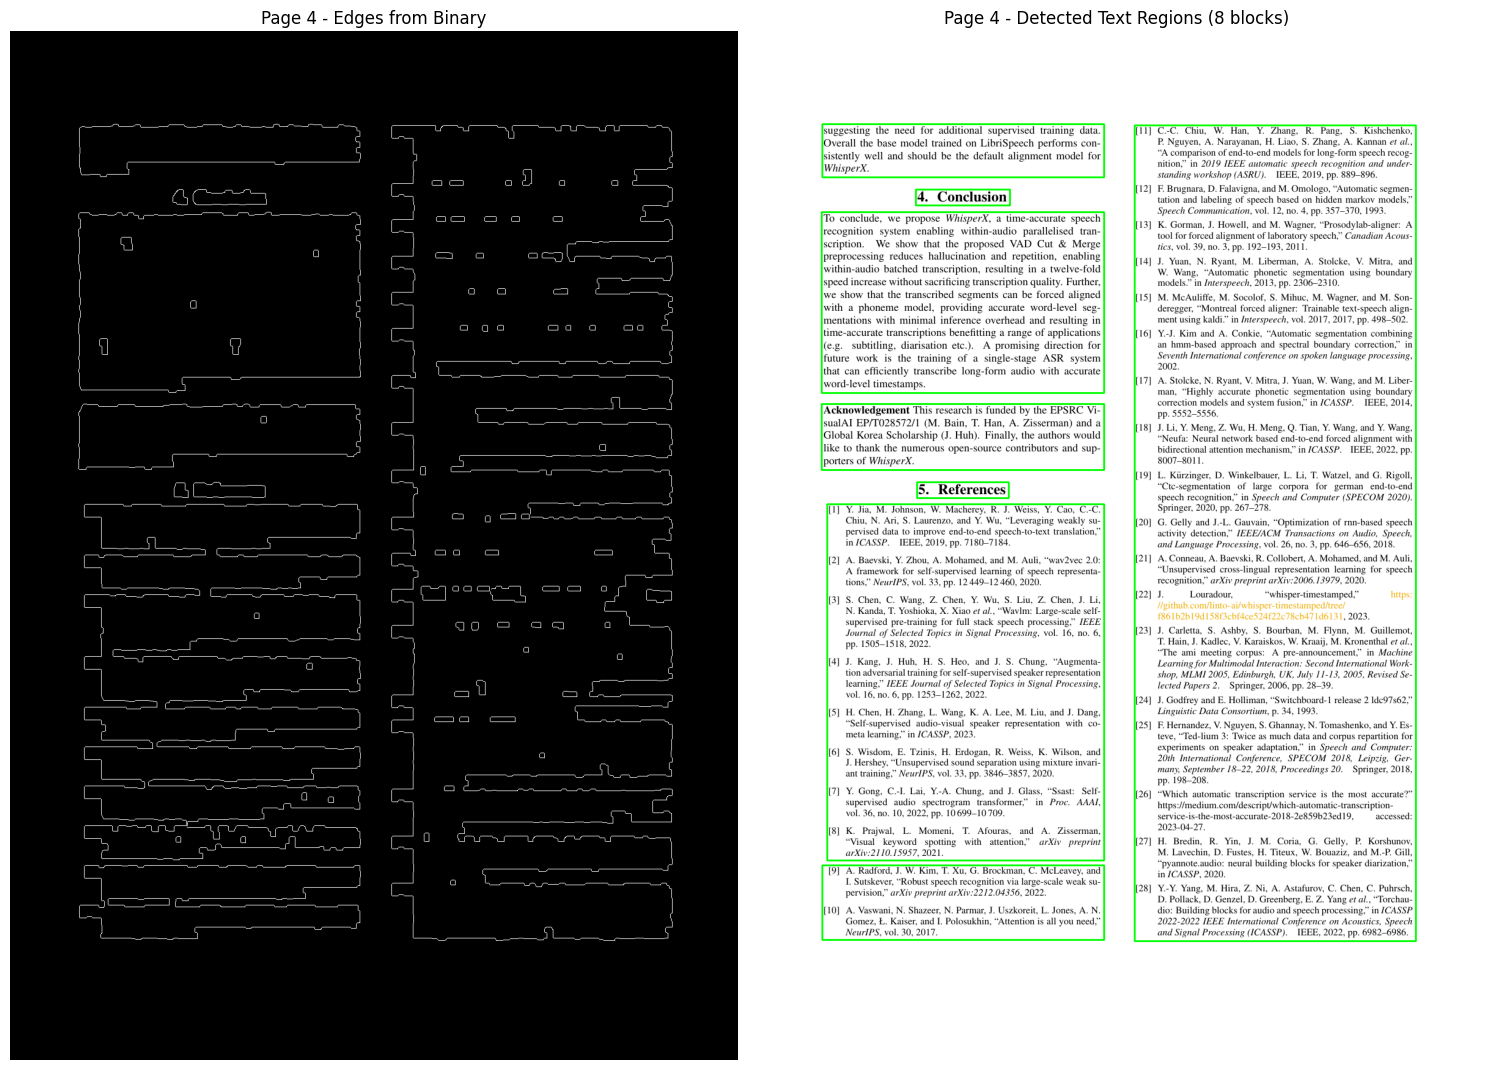

Processing Page 5 via Image Regions...
  Found 1 initial contours.
  Created 1 initial regions after pre-filtering.
  1 regions remaining after merging and size filtering.
  Extracted 1 text blocks.


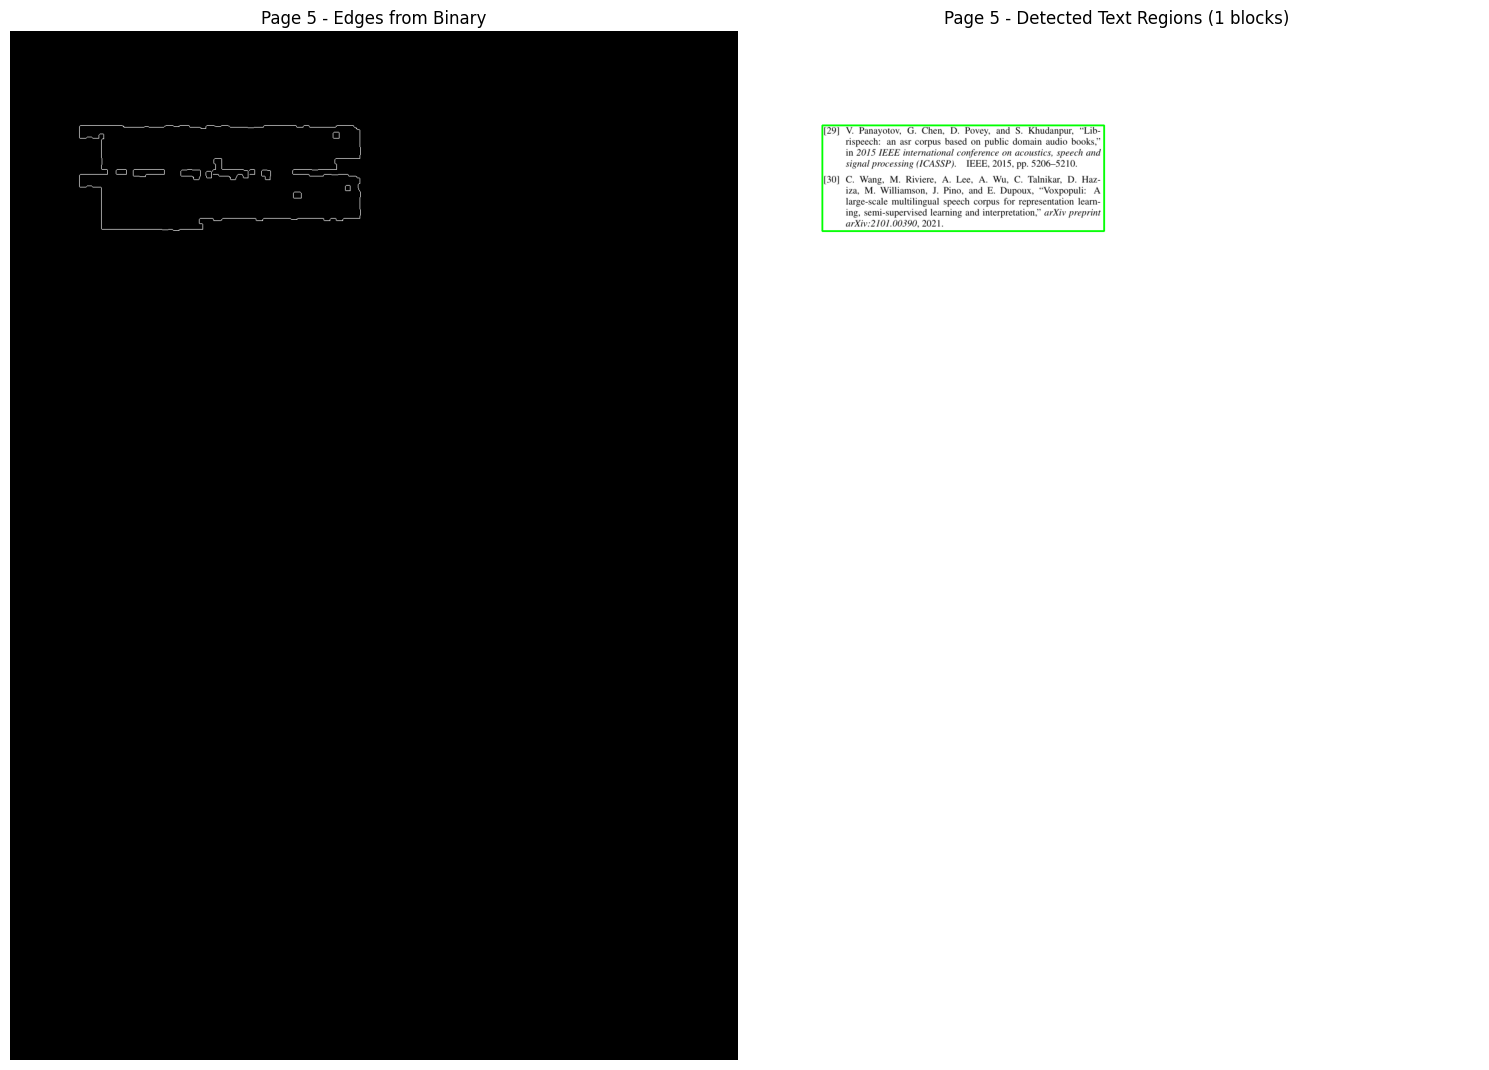

Finished extraction. Total elements: 74
Identifying potential watermarks...
  No potential watermarks found.
Sorting all elements for hierarchical processing...
Sorting complete.
Calculating hierarchy markers (child spans) based on text height...
Finished calculating child spans.
Building hierarchy tree...
  Identified 23 potential root nodes (chapters/sections).
Generating JSON output...
Finished generating JSON structure with 1 top-level items.
Saving structured JSON to: D:\DATA300\AudioBookSum\pdf\other\2303.00747v2_structured.json
Successfully saved JSON.
--- Processing finished in 4.47 seconds ---


In [9]:
import time
import os
DUMMY_NODE_HEIGHT = 1000

def extract_and_prepare_elements(pdf_path):
    """
    Opens PDF, extracts text elements using the provided function,
    ensures required keys are present, sorts by reading order per page,
    and returns a single list of all elements.
    """
    try:
        doc = pymupdf.open(pdf_path)
    except Exception as e:
        print(f"Error opening PDF {pdf_path}: {e}")
        return []

    all_elements = []
    num_pages = len(doc)
    print(f"Processing {num_pages} pages from {os.path.basename(pdf_path)}...")

    for i in range(num_pages):
        try:
            # Call the external extraction function (abstracted)
            page_elements = extract_page_text_via_image_regions(page=doc[i], visual_proof=True)

            # Validate and potentially enrich elements
            valid_page_elements = []
            for element in page_elements:
                 # Ensure essential keys exist (add defaults or skip if necessary)
                if not all(k in element for k in ["content", "occupy_space", "text_height_median"]):
                     print(f"    Warning: Skipping element on page {i+1} due to missing keys: {element.get('content', '[No Content]')[:50]}...")
                     continue
                element['page_num'] = i # Ensure correct page number is set
                valid_page_elements.append(element)


            # Sort elements on the current page by position (reading order)
            valid_page_elements.sort(key=lambda x: (x["occupy_space"].y0, x["occupy_space"].x0))
            all_elements.extend(valid_page_elements)

        except Exception as e:
            print(f"Error processing page {i + 1}: {e}")
            # Decide whether to continue or stop on page error
            continue

    print(f"Finished extraction. Total elements: {len(all_elements)}")
    doc.close() # Ensure the document is closed
    return all_elements


def identify_and_filter_watermarks(elements):
    """
    Identifies elements with identical stripped content appearing more than once
    and filters them out.
    """
    if not elements:
        return [], set()

    print("Identifying potential watermarks...")
    # Count occurrences of each unique stripped text content
    text_counts = collections.Counter(
        (el["content"].strip(), el.get("text_height_median", 0)) for el in elements if el.get("content")
    )
    watermark_candidates = {(text[0], text[1]) for text, count in text_counts.items() if count > 1 and text} 

    if watermark_candidates:
        print(f"  Identified potential watermarks ({len(watermark_candidates)} unique texts): {watermark_candidates}")
        # Filter out elements whose stripped content is in the watermark set
        filtered_elements = [
            el for el in elements
            if el.get("content") and (el["content"].strip(), el["text_height_median"]) not in watermark_candidates
        ]
        print(f"  Removed {len(elements) - len(filtered_elements)} watermark instances. Elements remaining: {len(filtered_elements)}")
        return filtered_elements, watermark_candidates
    else:
        print("  No potential watermarks found.")
        return elements, set()


def calculate_child_spans(elements):
    """
    Calculates the 'span' for each element, representing how many subsequent,
    smaller-height elements fall under it before encountering an element of
    equal or greater height. This is used to determine parent-child relationships.

    Uses a stack-based approach to find the "next greater or equal element" boundary.
    """
    if not elements:
        return []

    print("Calculating hierarchy markers (child spans) based on text height...")
    # Add a dummy element at the end with a very large height.
    # This ensures all elements in the stack are processed correctly without needing extra end-of-loop logic.
    try:
        dummy_element = elements[-1].copy() if elements else {} # Handle empty list case
        dummy_element["text_height_median"] = DUMMY_NODE_HEIGHT
    except KeyError:
         print("Error: Last element missing 'text_height_median'. Cannot create dummy node reliably.")
         # Fallback or raise error - using arbitrary large height if copy fails but list not empty
         dummy_element = {"text_height_median": DUMMY_NODE_HEIGHT} if elements else {}


    processing_list = elements + [dummy_element]
    num_processing = len(processing_list)
    # Stores how many elements immediately following element `i` are 'under' it (smaller height).
    child_span_counts = [0] * num_processing
    stack = [] # Stores indices of elements waiting for their scope boundary (next >= element)

    for idx, current_element in enumerate(processing_list):
        current_height = current_element.get("text_height_median", 0) # Default height if missing

        # While stack is not empty AND current element's height is >= stack top element's height:
        # The current element marks the end of the scope for the element at the top of the stack.
        while stack and current_height >= processing_list[stack[-1]].get("text_height_median", 0):
            parent_index = stack.pop()
            # Calculate the span: number of elements between parent and current element
            child_span_counts[parent_index] = idx - parent_index - 1

        # Push the index of the current element onto the stack
        stack.append(idx)

    print("Finished calculating child spans.")
    return child_span_counts[:-1]


def build_hierarchy(elements, child_span_counts):
    """
    Builds a tree structure using Node objects based on the elements and their
    calculated child spans. Identifies root nodes (potential chapters/sections).
    """
    if not elements or len(elements) != len(child_span_counts):
        print("Warning: Mismatch between elements and child spans, or list is empty. Cannot build hierarchy.")
        return [], [] 

    print("Building hierarchy tree...")
    nodes = [Node(el) for el in elements]
    num_nodes = len(nodes)

    for i in range(num_nodes):
        span = child_span_counts[i]
        if span > 0:
            # This node `i` is a parent. Add its direct children.
            current_child_idx = i + 1
            while current_child_idx < min(i + 1 + span, num_nodes):
                # Add node at `current_child_idx` as a child of node `i`
                nodes[i].add_child(nodes[current_child_idx])
                grandchild_span = child_span_counts[current_child_idx]
                current_child_idx += (grandchild_span + 1) # Move past the child and its descendants

    # Identify root nodes: typically nodes that have children (parents).
    root_nodes = [node for i, node in enumerate(nodes) if child_span_counts[i] > 0]

    if not root_nodes and nodes:
        print("  Warning: No parent nodes identified based on height/span. Assuming flat structure or single level.")
        # Let's check the span sum for that condition.
        if sum(child_span_counts) == 0:
             root_nodes = nodes
        else:
             # This case (nodes exist, spans exist, but no nodes selected as roots) seems unlikely with the logic.
             # If it happens, maybe select the first node or log an error.
             print("Ambiguous root node condition. Defaulting to all nodes as roots.")
             root_nodes = nodes
    elif not nodes:
        print("  No text elements to form a hierarchy.")
        root_nodes = []
    else:
        # Create an overarching single root node to ensure tree structure is maintained
        root_node = Node({"content": "Document Root", "occupy_space": pymupdf.Rect(0, 0, 0, 0), "text_height_median": 0})
        root_node.children = root_nodes

        
        print(f"  Identified {len(root_nodes)} potential root nodes (chapters/sections).")

    return nodes, [root_node] # Return all nodes and the identified roots


def generate_json_structure(root_nodes):
    """
    Generates a nested list of dictionaries (JSON structure) from the root nodes
    using Breadth-First Search (BFS) to traverse the hierarchy.
    """
    if not root_nodes:
        return []

    print("Generating JSON output...")
    output_json_list = []
    # Keep track of nodes already added to the JSON globally to handle
    # cases where the root detection might be imperfect or graphs are disconnected.
    visited_nodes = set()

    def bfs_to_dict(start_node):
        """Performs BFS from a node and builds the nested dictionary for its branch."""
        # Check if this node was already processed as part of another root's tree
        if start_node in visited_nodes:
            return None # Don't process this branch again

        # Use a queue for BFS: stores tuples of (node_to_process, dict_to_populate_for_that_node)
        # Initialize with the starting node and the dictionary that will represent it
        root_dict = {}
        queue = collections.deque([(start_node, root_dict)])
        # Keep track of nodes visited *within this specific BFS call* to prevent cycles within a component
        local_visited = {start_node}

        while queue:
            current_node, current_data_dict = queue.popleft()

            # Mark node as globally visited *after* processing its data
            visited_nodes.add(current_node)

            # Populate the dictionary for the current node
            content_text = current_node.content.get("content", "")
            # print(current_node.content.get("page_num"))
            current_data_dict.update({
                "name": f"[Page:{current_node.content.get("page_num", 0)}] " + content_text.strip(),
                "children": []
                })

            child_list = current_data_dict["children"]
            for child_node in current_node.children:
                # Process child only if not visited globally or within this BFS call
                if child_node not in visited_nodes and child_node not in local_visited:
                    local_visited.add(child_node)
                    child_data = {}
                    child_list.append(child_data) 
                    queue.append((child_node, child_data))

        return root_dict # Return the populated dictionary for the starting node's branch

    # Iterate through the identified root nodes
    for root in root_nodes:
        branch_dict = bfs_to_dict(root)
        if branch_dict: # Only add if the BFS generated a structure (i.e., node wasn't already visited)
            output_json_list.append(branch_dict)

    print(f"Finished generating JSON structure with {len(output_json_list)} top-level items.")
    return output_json_list


def save_to_json(data, output_path):
    """Saves the provided data structure to a JSON file."""
    print(f"Saving structured JSON to: {output_path}")
    try:
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        print("Successfully saved JSON.")
    except IOError as e:
        print(f"Error writing JSON file to {output_path}: {e}")
    except TypeError as e:
        print(f"Error serializing data to JSON (check data structure): {e}")


# --- Main Processing Function ---

def process_pdf_to_structured_json(input_pdf_path, output_json_path=None):
    """
    Main orchestrator function:
    1. Checks input path.
    2. Extracts and prepares text elements.
    3. Identifies and filters watermarks.
    4. Sorts elements globally for hierarchy processing.
    5. Calculates child spans based on height.
    6. Builds the node hierarchy.
    7. Generates the final JSON structure.
    8. Saves the JSON file.
    """
    start_time = time.time()
    print(f"\n--- Starting processing for: {input_pdf_path} ---")

    if not os.path.exists(input_pdf_path):
        print(f"Error: Input PDF not found at {input_pdf_path}")
        return

    if output_json_path is None:
        output_json_path = os.path.splitext(input_pdf_path)[0] + "_structured.json"

    # 1. Extract and Prepare Elements (Abstracted Call)
    elements = extract_and_prepare_elements(input_pdf_path)
    if not elements:
        print("No text elements extracted or processed. Aborting.")
        return

    # 2. Identify and Filter Watermarks
    elements, _ = identify_and_filter_watermarks(elements) # Watermark list ignored for now
    if not elements:
        print("No content remaining after watermark removal. Aborting.")
        return

    # 3. Sort All Elements Globally for Hierarchy Building
    #    Sort primarily by page, then y-position (top-to-bottom), then x-position (left-to-right).
    print("Sorting all elements for hierarchical processing...")
    elements.sort(key=lambda x: (
        x.get("page_num", 0),
        x.get("occupy_space").y0 if x.get("occupy_space") else 0,
        x.get("occupy_space").x0 if x.get("occupy_space") else 0
    ))
    print("Sorting complete.")
    # print(elements)
    # 4. Calculate Hierarchy Markers (Child Spans)
    child_span_counts = calculate_child_spans(elements)

    # 5. Build Hierarchy Tree
    all_nodes, root_nodes = build_hierarchy(elements, child_span_counts)
    if not root_nodes:
         print("No hierarchical structure could be determined. Aborting JSON generation.")
         return
    output_data = generate_json_structure(root_nodes)

    save_to_json(output_data, output_json_path)

    end_time = time.time()
    print(f"--- Processing finished in {end_time - start_time:.2f} seconds ---")
    return elements, output_data

pdf_to_process = r"D:\DATA300\AudioBookSum\pdf\other\2303.00747v2.pdf"

if pdf_to_process == "path/to/your/document.pdf":
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!! Please update the 'pdf_to_process' variable in the   !!!")
    print("!!! '__main__' block of the script before running.        !!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
elif not os.path.exists(pdf_to_process):
        print(f"\nWarning: The specified PDF file does not exist: {pdf_to_process}")
        print("Script will not run processing.")
else:
    # Run the main processing pipeline
    content, content_json = process_pdf_to_structured_json(pdf_to_process)
# print(content)

This still struggle with tainted paper/ more than 1 central reading flow

In [10]:
# %%time
# doc = pymupdf.open(pdf_to_process)
# text = ""
# median_collection = []

# for i in range(len(doc)):
#     extracted_pages = sorted(extract_page_text_via_image_regions(pdf_to_process, page_num =i, visual_proof=False), \
#         key = lambda x: [x["occupy_space"].y0, x["occupy_space"].x0])


In [11]:
import copy
import re 
page_pattern = re.compile(r'^\[Page:\s*(\d+)\s*\]\s*(.*)', re.DOTALL)
# Get the page number from the string and if it is the same as the first, remove it in the new string

def get_depth_mapping(data):
    """
    Performs a Breadth-First Search (BFS) on the nested data structure
    and counts the number of nodes at each depth level.

    Args:
        data: The nested data structure (e.g., loaded from JSON).
              Assumes a structure where nodes might have a 'children' key
              containing a list of child nodes.

    Returns:
        A list where the index represents the depth level (starting from 0)
        and the value represents the number of nodes at that depth.
    """
    from collections import deque
    if not data:
        return []

    depth_counts = []
    queue = deque([(data, 0)])  # Initialize queue with the root node and depth 0

    while queue:
        current_node, depth = queue.popleft()
        # print(current_node[0])
        current_node = current_node[0] if isinstance(current_node, list) else current_node
        # Ensure the depth list is long enough
        while len(depth_counts) <= depth:
            depth_counts.append(0)
        # Increment the count for the current depth
        depth_counts[depth] += 1
        # Add children to the queue if they exist
        if isinstance(current_node, dict) and 'children' in current_node:
            print(f"Processing node at depth {depth}: {current_node.get('name', 'Unnamed Node')}")
            children = current_node['children']
            for child in children:
                queue.append((child, depth + 1))
    return depth_counts

def collect_all_text(node, page_number= -1):
    """Recursively collects 'name' fields from a node and all its descendants."""
    if not isinstance(node, dict):
        return "" 
    current_name = str(node.get("name", "")).strip()
    parent_match = page_pattern.match(current_name)
    parent_page_number = int(parent_match.group(1)) if parent_match else -1
    text_parts = []
    if parent_page_number == page_number:
        #Remove the page_number from current_name
        current_name = current_name[parent_match.end():].strip() if parent_match else current_name
    if current_name:
        text_parts.append(current_name)

    # Recursively collect text from children
    if "children" in node and isinstance(node["children"], list):
        for child in node["children"]:
            child_text = collect_all_text(child, parent_page_number)
            if child_text:
                 text_parts.append(child_text)

    # Join collected parts with a space
    return " ".join(text_parts).strip() 

# Modified recursive function to clone and merge descendant text
def clone_and_modify_recursive(node, current_depth, target_merge_start_level):
    """
    Recursive helper function to clone the structure. 
    If a node is at target_merge_start_level - 1, it collects all text 
    from its children and their descendants into its own 'name' field, 
    discarding the children.
    """
    if not isinstance(node, dict):
        return None 
    

    cloned_node = {
        "name": node.get("name", ""),
        "children": [] 
    }

    target_parent_level = target_merge_start_level

    if current_depth == target_parent_level:
        original_name = str(node.get("name", "")).strip()
        concatenated_text = ""
        match = page_pattern.match(original_name)
        if match:
            page_number = int(match.group(1))
        else:
            page_number = -1  # Default to -1 if no match
        if "children" in node and isinstance(node["children"], list):
            for child in node["children"]:
                 descendant_text = collect_all_text(child, page_number) 
                 if descendant_text:
                     concatenated_text += descendant_text + " "
        merged_name = concatenated_text.strip()
        merged_name_match = page_pattern.match(merged_name)
        merged_name_page = int(merged_name_match.group(1)) if merged_name_match else -1
        if merged_name_page == page_number:
            merged_name = merged_name[merged_name_match.end():].strip() if merged_name_match else merged_name
        if original_name and merged_name:
             cloned_node["name"] = original_name + " " + merged_name
        elif merged_name:
             cloned_node["name"] = merged_name
        cloned_node["children"] = [] 
    
    elif current_depth < target_parent_level:
        if "children" in node and isinstance(node["children"], list):
            for child in node["children"]:
                # Recurse: process child at next depth, same target level
                cloned_child = clone_and_modify_recursive(child, current_depth + 1, target_merge_start_level)
                if cloned_child: # Add valid cloned children
                    cloned_node["children"].append(cloned_child)
    if len(cloned_node.get("name")):
         return cloned_node
    else:
         return None

def process_structure_merge_after(data, merge_start_level):
    """
    Clones the nested data structure and merges the 'name' fields
    of all nodes at and below 'merge_start_level' into their respective 
    ancestor node at 'merge_start_level - 1'.

    Args:
        data: The nested data structure (list of dicts or a single dict).
        merge_start_level: The depth level (0-indexed) from which merging should begin.
                           Nodes at level 'merge_start_level - 1' will absorb their descendants.

    Returns:
        The cloned and modified data structure, or a deep copy if merging is not possible.
    """
    if merge_start_level <= 0:
        print(f"Error: merge_start_level must be 1 or greater (to target children of level 0 or deeper). Returning original structure.")
        return copy.deepcopy(data)

    target_parent_level = merge_start_level
    print(f"Attempting to merge content from level {merge_start_level} and deeper into nodes at level {target_parent_level}.")

    if isinstance(data, list):
        # If the input is a list of root nodes (depth 0)
        new_data_list = []
        for root_node in data:
             cloned_root = clone_and_modify_recursive(root_node, 0, merge_start_level)
             if cloned_root:
                 new_data_list.append(cloned_root)
        
        return new_data_list
    elif isinstance(data, dict):
         cloned_root = clone_and_modify_recursive(data, 0, merge_start_level)
         return cloned_root 
    else:
         print("Error: Input data must be a list or a dictionary. Returning None.")
         return None

def chunk_text_v2(json_data, chunk_size=50000, chunk_overlap=100):
    """
    Splits text blocks into smaller chunks for processing.
    Uses RecursiveTextSplitter from LangChain for efficient splitting.
    """
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    
    import pandas as pd
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    chunked_data = []
    depth_map = get_depth_mapping(json_data) 
    print(f"Nodes per depth level: {depth_map}")
    new_structure = None 
    if depth_map and len(depth_map) > 1:
        try:
            # Find the maximum count starting from index 1
            max_nodes = max(depth_map[1:]) 
            # Find the first index (level) corresponding to that max count, searching from index 1
            content_level_index = depth_map.index(max_nodes, 1)-1
            print(f"Potential content layer (most nodes, excluding root): Level {content_level_index} with {depth_map[content_level_index]} nodes")

            # Call the processing function with the identified level as the start of merging
            print(f"Merging content starting from level: {content_level_index}")
            # Pass the original data and the level where merging should START
            new_structure = process_structure_merge_after(json_data, content_level_index) 

            # Optional: print or save the new structure
            if new_structure is not None: # Check if structure was generated 
                print("\nNew Structure Generated.")
                count = 0
                if isinstance(new_structure, list):
                    count = len(new_structure)
                elif isinstance(new_structure, dict):
                    # Count 1 if dict is not None and has content
                    count = 1 if (new_structure.get("name") or new_structure.get("children")) else 0 
                
                print(f"Generated new structure with {count} top-level item(s).")

                output_filename = 'merged_structure.json'
                print(f"Saving merged structure to {output_filename}")
                with open(output_filename, 'w', encoding='utf-8') as f:
                    json.dump(new_structure, f, indent=2, ensure_ascii=False)
                print("Save complete.")

            else:
                print("Generated structure is empty or None.")

        except ValueError:
            print("Could not find a content level after the root level (depth map might be too short or max search failed).")
            print("No merging performed.")
            new_structure = copy.deepcopy(json_data) # Keep original if no merge level found

    elif depth_map and len(depth_map) == 1:
        print(f"Only one level (Level 0) found with {depth_map[0]} nodes. Cannot determine content level for merging.")
        new_structure = copy.deepcopy(json_data) # Keep original
    else:
        print("Could not generate depth map or depth map is empty.")
        new_structure = None # Indicate failure
    # Using the new more concatenated structure, we can chunk the text based on chapters/ a reasonalbe content size
    if new_structure is None or not isinstance(new_structure, (list, dict)):
        print("No valid structure to chunk. Returning empty list.")
        return []
    
    from collections import deque
    queue = deque([new_structure])  
    content = []
    while queue:
        current_node = queue.popleft()
        if len(current_node):
            current_node = current_node[0] if isinstance(current_node, list) else current_node
            
        if isinstance(current_node, dict):
            if 'children' in current_node and not current_node['children']:
                content_length = len(current_node.get('name', '').split(' '))
                content.append({'text': current_node.get('name'),'length':content_length})
                
            if 'children' in current_node and isinstance(current_node['children'], list):
                for child in current_node['children']:
                    queue.append(child)
    
    content_df = pd.DataFrame(content)
    # print(content_df)
    threshold = content_df['length'].quantile(0.75)
    # If the record is has a lower length than the threshold, we consider it a short text and merge into the next chunk
    chunked_data = []
    chunked_block = []
    save = ""
    for index, row in content_df.iterrows():
        if save:
            text = save + "\n" + row['text']
            save = ""
        else:
            text = row['text']
        length = row['length']
        if length < threshold:
            save += "\n" + text.strip()
            continue
        else:
            chunked_block = text_splitter.split_text(text)
        if not chunked_block:
            print(f"Warning: Empty chunk generated for text: {text}")
            continue
        chunked_data.extend(chunked_block)
    return chunked_data, sum(content_df['length'].tolist())
chunk_text_v2(content_json, chunk_size=50000, chunk_overlap=100)

Processing node at depth 0: [Page:0] Document Root
Processing node at depth 1: [Page:0] REFERENCES
Linked references are available on JSTOR for this article:
https://www.jstor.org/stable/10.2307/26310871?seq=1&cid=pdf-
reference#references_tab_contents
You may need to log in to JSTOR to access the linked references.
Processing node at depth 1: [Page:1] Disease in Pictures of People with AIDS
Processing node at depth 1: [Page:1] lukas engelmann
Processing node at depth 1: [Page:1] Summary: The photography of people with AIDS has been subject to numer-
ous critiques in the 1980s and has become a controversial way of visualizing the
AIDS epidemic. While most of the scholarly work on AIDS photography is based
in cultural studies and concerned with popular representations, the clinical value
of photographs of people with AIDS usually remains overlooked. This article
addresses photographs as a “way of seeing” AIDS that contributed crucially to the
making of the disease entity AIDS within the

(['[Page:0] REFERENCES\nLinked references are available on JSTOR for this article:\nhttps://www.jstor.org/stable/10.2307/26310871?seq=1&cid=pdf-\nreference#references_tab_contents\nYou may need to log in to JSTOR to access the linked references.\n[Page:1] Disease in Pictures of People with AIDS [Page:7] istic of the early years of the epidemic. In regard to a broader visual culture\nof AIDS, which is the subject of the first section, clinical photography has\noften been identified as a dominating visual regime, contaminating many\nof the often-criticized photographs of PWA to be found in media and art.\nBy foregrounding a few clinical photographs, which are analyzed in depth\nin the second section, the article rejects this assumption and shows that\nphotography served within and outside of the clinic to visualize a disease\nin relation to the body of the patient. This rather trivial finding encloses\nan argument to be made on the early history of AIDS, in which photog-\nraphy’s contrib

In [12]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# def chunk_text(text_blocks, chunk_size=100000, chunk_overlap=100):
#     """
#     Chunk text blocks into smaller pieces while preserving page and bounding box information.
    
#     Args:
#         text_blocks (list): List of dictionaries containing text with metadata (page, bbox, etc.)
#         chunk_size (int): Maximum size of each chunk in characters
#         chunk_overlap (int): Number of overlapping characters between chunks
        
#     Returns:
#         list: List of dictionaries containing chunks with preserved metadata
#     """
#     chunked_data = []  
#     text_splitter = RecursiveCharacterTextSplitter(
#         chunk_size=chunk_size,
#         chunk_overlap=chunk_overlap,
#         length_function=len,
#     )
    
#     # First combine all text blocks into a single document string for chunking
#     combined_text = ""
#     metadata_map = {}  # Map character positions to original metadata
#     current_position = 0
    
#     # Process each text block and map character positions to metadata
#     for idx, block in enumerate(text_blocks):
#         # Get text and metadata
#         text = block.get("content", "")
#         if not text:
#             continue
            
#         block_length = len(text)
#         page = block.get("page_num", 0)
#         bbox = block.get("occupy_space", None)
#         text_height = block.get("text_height_median", None)
        
#         # Map each character position in the combined text to its source metadata
#         for i in range(current_position, current_position + block_length):
#             metadata_map[i] = {
#                 "page": page,
#                 "bbox": bbox,
#                 "text_height": text_height,
#                 "original_block_index": idx
#             }
        
#         # Add text to combined string with a marker between blocks
#         combined_text += text + " [BLOCK_BREAK] "
#         current_position += block_length + len(" [BLOCK_BREAK] ")
    
#     # Split the combined text into chunks
#     chunks = text_splitter.split_text(combined_text)
    
#     # For each chunk, determine the predominant page and bounding box
#     chunk_start = 0
#     for i, chunk in enumerate(chunks):
#         # Find the start position of this chunk in the combined text
#         if i == 0:
#             start_pos = 0
#         else:
#             # Look for chunk in the vicinity of where we expect it
#             search_start = max(0, chunk_start - chunk_overlap)
#             search_text = combined_text[search_start:search_start + len(chunk) + 100]
#             rel_pos = search_text.find(chunk[:50])
#             if rel_pos != -1:
#                 start_pos = search_start + rel_pos
#             else:
#                 # Fallback if exact match not found
#                 start_pos = chunk_start
        
#         # Update for next iteration
#         chunk_start = start_pos + len(chunk) - chunk_overlap
            
       
#         page_counts = {}
#         bbox_by_page = {}
        
#         for j in range(start_pos, min(start_pos + len(chunk), len(combined_text))):
#             if j in metadata_map:
#                 page = metadata_map[j]["page"]
#                 if page not in page_counts:
#                     page_counts[page] = 0
#                     bbox_by_page[page] = []
                    
#                 page_counts[page] += 1
#                 if metadata_map[j]["bbox"] and metadata_map[j]["bbox"] not in bbox_by_page[page]:
#                     bbox_by_page[page].append(metadata_map[j]["bbox"])
        
#         # Find predominant page
#         predominant_page = max(page_counts.items(), key=lambda x: x[1])[0] if page_counts else 0
        
#         # Create enhanced chunk with metadata
#         enhanced_chunk = {
#             "text": chunk.replace(" [BLOCK_BREAK] ", "\n\n"),
#             "page": predominant_page,
#             "bbox_list": bbox_by_page.get(predominant_page, []),
#             "start_position": start_pos,
#             "chunk_index": i
#         }
        
#         chunked_data.append(enhanced_chunk)
    
#     return chunked_data

In [13]:
import os
import json
import re
import difflib
from collections import defaultdict
from dotenv import load_dotenv
from typing import List, Dict, Any, Tuple, Optional, DefaultDict, Type

from pydantic import BaseModel, Field

try:
    from langchain_google_genai import ChatGoogleGenerativeAI
    # Define the specific LLM type hint if possible
    LLMClientType = ChatGoogleGenerativeAI
except ImportError:
    print("Warning: langchain-google-genai not found. Using 'Any' for LLM type hint.")
    print("Please install it: pip install langchain-google-genai")
    LLMClientType = Any 
    
load_dotenv()
class EvidenceSnippet(BaseModel):
    """Represents a single verbatim evidence snippet."""
    verbatim_text: str = Field(..., description="The exact verbatim text snippet extracted from the document, including any '[Page X]' annotation if present at the beginning of the snippet.")

class SummaryAndEvidence(BaseModel):
    """Schema for the desired LLM output containing summary and evidence."""
    summary: str = Field(..., description="A concise summary based solely on the provided document content.")
    evidence: List[EvidenceSnippet] = Field(..., description="A list of verbatim evidence snippets supporting the key points of the summary.")


def _find_matching_block(
    segment_text: str,
    page_hint: Optional[int],
    page_to_blocks: DefaultDict[int, List[Dict[str, Any]]],
    min_similarity_threshold: float = 0.6
) -> Tuple[Optional[Dict[str, Any]], float]:
    """
    Finds the best matching text block for a given segment text.
    (Implementation remains the same as the previous version)
    """
    norm_segment = ' '.join(segment_text.split())
    if not norm_segment:
        return None, 0.0

    best_match_block: Optional[Dict[str, Any]] = None
    highest_similarity: float = 0.0

    search_pages: List[int] = []
    # If page_hint is None or 0 (or less, though 0 is the first valid index), search all pages.
    if page_hint is None or page_hint < 1:
        print(f'Page hint is {page_hint}, searching all pages for: "{segment_text[:50]}..."')
        # Search pages in order, or reverse order if preferred (e.g., recent pages first)
        search_pages = list(page_to_blocks.keys())
        # Optionally sort if a specific order is desired, e.g., search_pages.sort()
    # If a valid page hint (>= 0) is given and exists in blocks, prioritize it.
    elif page_hint in page_to_blocks:
        print("page_hint in page_to_blocks")
        search_pages.append(page_hint)
        # Add a padding of 2 page back and forth just in case:
        search_pages.extend(
            [page_hint + i for i in range(-2, 3) if (page_hint + i) in page_to_blocks]
        )

    # If hint is invalid or not found, search all pages
    else:
         print(f'Page hint {page_hint} not found in page_to_blocks, searching all pages for: "{segment_text[:50]}..."')
         search_pages = list(page_to_blocks.keys())


    for page_num in search_pages:
        for block in page_to_blocks.get(page_num, []):
            block_text = block.get("norm_text", "")
            if not block_text:
                continue

            if norm_segment in block_text:
                return block, 1.0

            # Calculate similarity if not contained
            similarity = difflib.SequenceMatcher(None, norm_segment, block_text).ratio()

            if similarity > highest_similarity:
                highest_similarity = similarity
                best_match_block = block
                # Optional: Add a condition to return early if similarity is very high (e.g., > 0.95)
                if highest_similarity > 0.95:
                    print(f"  High similarity ({highest_similarity:.2f}) match found on page {page_num+1}") # Debug
                    return best_match_block, highest_similarity


    if highest_similarity >= min_similarity_threshold:
        # print(f"  Best match found on page {best_match_block.get('page_num', -1)+1} with similarity {highest_similarity:.2f}") # Debug
        return best_match_block, highest_similarity

    # print(f"  No suitable match found (highest similarity {highest_similarity:.2f})") # Debug
    return None, 0.0


def _extract_page_number_from_text(text: str) -> Optional[int]:
    """
    Extracts 0-indexed page number from '[Page:X]' annotation at the start.
    (Implementation remains the same)
    """
    page_match = re.match(r'\[Page:(\d+)\]', text)
    if page_match:
        try:
            return int(page_match.group(1))
        except (ValueError, IndexError):
            return None
    return None


def _process_segment(
    raw_snippet_text: str,
    source_page_hint: Optional[int], 
    page_to_blocks: DefaultDict[int, List[Dict[str, Any]]],
    min_word_threshold: int
) -> Optional[Dict[str, Any]]:
    """
    Processes a raw snippet text provided by the LLM (via structured output).
    (Implementation remains the same as the previous version, as it operates
     on the extracted snippet text string)
    """
    original_segment_text = raw_snippet_text.strip()
    if len(original_segment_text.split()) < min_word_threshold:
        return None

    page_annotation = _extract_page_number_from_text(original_segment_text)
    text_for_matching = re.sub(r'^\[Page:\s*\d+\]\s*', '', original_segment_text).strip()
    if not text_for_matching:
        return None
    # If we encounter multiple page annotations, we split up the text and go through all of them

    page_hint_for_search = page_annotation if page_annotation is not None else source_page_hint

    matched_block, match_similarity = _find_matching_block(
        text_for_matching, page_hint_for_search, page_to_blocks
    )

    if matched_block:
        actual_page_num = matched_block.get("page", 0)
        correct_page_annotation_str = f"[Page:{actual_page_num}]"

        if page_annotation == actual_page_num:
            display_text = original_segment_text
            if page_annotation is None and actual_page_num >= 0:
                 display_text = f"{correct_page_annotation_str} {text_for_matching}"
        elif page_annotation is not None and page_annotation != actual_page_num:
             display_text = f"{correct_page_annotation_str} {text_for_matching}"
        else:
             display_text = f"{correct_page_annotation_str} {text_for_matching}"

        return {
            "page": actual_page_num,
            "text": display_text.strip(),
            "bbox": matched_block.get("bbox"),
        }
    else:
        print("No matching block found for segment text. Assigning default page annotation.")
        assigned_page_num = page_hint_for_search if page_hint_for_search is not None else source_page_hint
        assigned_page_annotation_str = f"[Page:{assigned_page_num}]"

        if page_annotation is None:
            display_text = f"{assigned_page_annotation_str} {text_for_matching}"
        else:
            display_text = original_segment_text

        return {
            "page": assigned_page_num,
            "text": display_text.strip(),
            "bbox": None,
        }



def identify_interesting_points_structured(
    chunked_data: List[Dict[str, Any]],
    llm, 
    output_schema: Type[BaseModel],
    text_blocks: List[Dict[str, Any]],
    cache_file_name: str,
    min_snippet_word_count: int = 5,
    is_one_p:bool = True
) -> Tuple[Optional[str], List[Dict[str, Any]]]:
    """
    Identifies summary and evidence snippets using an LLM with structured output.

    Relies on the LLM's ability to populate the provided Pydantic schema.
    The prompt should instruct the LLM to perform the summarization and extraction
    task and fill the schema fields accordingly.

    Args:
        chunked_data: List of dictionaries ('text', 'page').
        llm: Initialized LLM model/client instance supporting structured output
             (e.g., langchain_google_genai.ChatGoogleGenerativeAI).
        output_schema: The Pydantic BaseModel class defining the desired output structure
                      (e.g., SummaryAndEvidence).
        text_blocks: Original list of text block dictionaries from PDF extraction.
        cache_file_name: Path to the JSON file for caching results.
                         Cache Format matches the output_schema structure.
        min_snippet_word_count: Minimum word count for an evidence snippet.
    Returns:
        A tuple containing:
        - The generated summary string (or None).
        - A list of processed evidence snippet dictionaries, sorted.
    """
    summary_result: Optional[str] = None
    processed_segments: List[Dict[str, Any]] = []

    if not chunked_data:
        print("Warning: No chunked data provided.")
        return None, []

    # --- 1. Prepare Block Index ---
    page_to_blocks: DefaultDict[int, List[Dict[str, Any]]] = defaultdict(list)
    print(text_blocks)
    for block in text_blocks:
        content = block.get("text", "")
        page_num = block.get("page")
        if content and page_num is not None:
            block["norm_text"] = ' '.join(content.split())
            page_to_blocks[page_num].append(block)
    print("Finish preparing page to blocks index.")
    # --- 2. Cache Handling ---
    cache_loaded = False
    if os.path.exists(cache_file_name):
        try:
            print(f"Attempting to load cached results from {cache_file_name}")
            with open(cache_file_name, "r", encoding="utf-8") as f:
                cached_data_raw = json.load(f)

            cached_data_structured = output_schema.model_validate(cached_data_raw)

            summary_result = cached_data_structured.summary
            raw_cached_snippets = [snippet.verbatim_text for snippet in cached_data_structured.evidence]

            temp_processed_segments = []
            last_page_annot = None
            for snippet_text in raw_cached_snippets:
                 possible_page = page_pattern.match(snippet_text)
                 possible_page_num = int(possible_page.group(1)) if possible_page else None
                 if not possible_page_num:
                     possible_page_num = last_page_annot
                 else:
                     last_page_annot = possible_page_num
                 processed = _process_segment(snippet_text, possible_page_num, page_to_blocks, min_snippet_word_count)
                 if processed:
                     temp_processed_segments.append(processed)

            processed_segments = temp_processed_segments

            if summary_result or processed_segments:
                print(f"Cache loaded and validated: Summary: {summary_result is not None}, Snippets: {len(processed_segments)}")
                cache_loaded = True
            else:
                print("Cache file loaded but resulted in no valid summary or snippets after processing/validation. Will regenerate.")

        except json.JSONDecodeError:
            print(f"Error decoding JSON from cache file {cache_file_name}. Will regenerate.")
        except Exception as e: 
            print(f"Error loading, validating, or processing cache file {cache_file_name}: {e}. Will regenerate.")

    if not cache_loaded:
        print("Generating new summary and evidence points using LLM with structured output...")

        prompt_template_str = os.getenv("SUMMARY_EVIDENCE_PROMPT_STRUCTURED") 
        if not prompt_template_str:
            print("Error: Environment variable 'SUMMARY_EVIDENCE_PROMPT_STRUCTURED' not set.")
            print("This prompt should instruct the LLM to analyze the text and populate the required schema.")
            return None, []

        try:
            response_object = SummaryAndEvidence(summary="", evidence=[])
            if is_one_p:
                all_text_for_llm = ""
                for chunk in chunked_data:
                    all_text_for_llm += " " + chunk.strip()

                if not all_text_for_llm.strip():
                    print("Error: No text content found in chunked_data to send to LLM.")
                    return None, []
                
                final_prompt = prompt_template_str + "\n\nDocument Content:\n" + all_text_for_llm.strip()
                
                try:
                    structured_llm = llm.with_structured_output(output_schema)
                    print("LLM configured for structured output.")
                except AttributeError:
                    print(f"Error: The provided LLM client object (type: {type(llm)}) does not appear to have a '.with_structured_output' method.")
                    print("Please ensure you are using a compatible LLM client and library version (e.g., recent langchain-google-genai).")
                    return None, []
                except Exception as e:
                    print(f"Error configuring LLM for structured output: {e}")
                    return None, []


                # --- Invoke LLM ---
                print("Sending request to LLM for structured response...")
                response: SummaryAndEvidence = structured_llm.invoke(final_prompt)
                print("Structured response received from LLM.")
                response_object.summary += " " + response.summary.strip()
                response_object.evidence.extend(response.evidence)
            else:
                # for every chunk, we send 1 request and concatenate the responses into to a big object
                for chunk_idx, chunk in enumerate(chunked_data):
                    chunk_text = chunk.strip()
                    # print(f"Processing chunk {chunk_idx + 1}/{len(chunked_data)}: {chunk_text}")  # Debug output
                    if not chunk_text:
                        print("Warning: Empty text block found in chunked_data. Skipping.")
                        continue

                    # Prepare the prompt for this chunk
                    final_prompt = prompt_template_str + "\n\nDocument Content:\n" + chunk_text + (("\n\n Summary of previous chunks:\n" + response_object.summary.strip()) if response_object.summary else "")
                    # print(final_prompt[:1000])  # Print the first 1000 characters of the prompt for debugging
                    try:
                        structured_llm = llm.with_structured_output(output_schema)
                        print("LLM configured for structured output.")
                    except AttributeError:
                        print(f"Error: The provided LLM client object (type: {type(llm)}) does not appear to have a '.with_structured_output' method.")
                        print("Please ensure you are using a compatible LLM client and library version (e.g., recent langchain-google-genai).")
                        return None, []
                    except Exception as e:
                        print(f"Error configuring LLM for structured output: {e}")
                        return None, []

                    print(f"Sending request to LLM for chunk: {chunk_idx}")
                    response: SummaryAndEvidence = structured_llm.invoke(final_prompt)
                    print("Structured response received from LLM.")

                    # Merge the response into the main response_object
                    response_object.summary += response.summary + "\n Next: \n" 
                    response_object.evidence.extend(response.evidence)
                    
            summary_result = response_object.summary
            raw_snippet_objects = response_object.evidence
            raw_snippets_text = [snippet.verbatim_text for snippet in raw_snippet_objects]

            print(f"Extracted Summary: {summary_result is not None}. Extracted Raw Snippets: {len(raw_snippets_text)}")
            processed_segments = []
            cache_data_to_save = response_object
            
            last_page_annot = None
            for snippet_text in raw_snippets_text:
                possible_page = page_pattern.match(snippet_text)
                possible_page_num = int(possible_page.group(1)) if possible_page else None
                if not possible_page_num:
                     possible_page_num = last_page_annot
                else:
                     last_page_annot = possible_page_num
                processed_section = _process_segment(snippet_text, possible_page_num, page_to_blocks, min_snippet_word_count)
                
                if processed_section:
                    processed_segments.append(processed_section)

            try:
                os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
                with open(cache_file_name, "w", encoding="utf-8") as f:
                    # Use Pydantic's .dict() method for robust serialization
                    json.dump(cache_data_to_save.model_dump(), f, ensure_ascii=False, indent=2)
                print(f"Saved structured LLM response to cache: {cache_file_name}")
            except IOError as e:
                print(f"Error writing cache file {cache_file_name}: {e}")
            except TypeError as e:
                print(f"Error serializing structured data for cache file {cache_file_name}: {e}")
                print("Problematic data structure:", cache_data_to_save)


        except Exception as e:
            print(f"Error during LLM interaction or processing structured output: {e}")
            import traceback
            traceback.print_exc()
            summary_result = None
            processed_segments = []

    print(f"Final results: Summary: {'Yes' if summary_result else 'No'}, Processed Snippets: {len(processed_segments)}")

    return summary_result, processed_segments

In [14]:
def highlight_interesting_points(pdf_path, interesting_points, output_path):
    """Add highlights to the interesting points in the PDF with complete text block highlighting."""
    doc = pymupdf.open(pdf_path)
    
    # Using cyan highlight color for main content
    highlight_color = (0, 1, 1)  # RGB for cyan
    fail_count = 0
    success_count = 0
    
    for point in interesting_points:
        print(f"Processing point: {point}")
        page_num = point["page"]
        page = doc[page_num]
        text = point["text"]
        if not text:
            print(f"Empty text for page {page_num}")
            continue
            
        # Extract content without page annotations for better matching
        clean_text = re.sub(r'\[Page:\s*\d+\]\s*', '', text).strip()
        if not clean_text:
            continue
            
        # Try exact match first
        text_instances = page.search_for(clean_text)
        
        found_matches = []
        if not text_instances:
           
            normalized_text = ' '.join(clean_text.split())
            text_instances = page.search_for(normalized_text)
            
            # Method 2: Try with key phrases and collect all matches to combine later
            if len(normalized_text.split()) > 10:
                # Extract significant phrases (5-8 words)
                words = normalized_text.split()
                for i in range(len(words) - 5):
                    phrase = ' '.join(words[i:i+min(8, len(words)-i)])
                    if len(phrase) > 15:  # Only phrases with enough content
                        phrase_instances = page.search_for(phrase)
                        if phrase_instances:
                            found_matches.extend(phrase_instances)
            
            
            if '.' in normalized_text:
                sentences = [s.strip() for s in normalized_text.split('.') if len(s.strip()) > 15]
                for sentence in sentences:
                    sentence_instances = page.search_for(sentence)
                    if sentence_instances:
                        found_matches.extend(sentence_instances)
        
        # If we found partial matches, combine their bounding boxes to highlight full area
        if found_matches and not text_instances:
            if len(found_matches) >= 2:
                found_matches.sort(key=lambda r: (r[1], r[0]))  
                
                # Combine all matches into one larger rectangle
                x0 = min(rect[0] for rect in found_matches)
                y0 = min(rect[1] for rect in found_matches)
                x1 = max(rect[2] for rect in found_matches)
                y1 = max(rect[3] for rect in found_matches)
                
                # Create a single combined rectangle that covers all matches
                combined_rect = (x0, y0, x1, y1)
                text_instances = [combined_rect]
            else:
                text_instances = found_matches
        
        # Highlight found instances or use bbox as fallback
        if text_instances:
            for inst in text_instances:
                highlight = page.add_highlight_annot(inst)
                highlight.set_colors(stroke=highlight_color)
                highlight.update()
            success_count += 1
        elif point.get("bbox_list") and isinstance(point["bbox_list"], list) and point["bbox_list"]:
            for bbox in point["bbox_list"]:
                if bbox: 
                    r = page.add_highlight_annot(bbox)
                    r.set_colors(stroke=highlight_color)
                    r.update()
            success_count += 1
        elif point.get("bbox"):
            # Single bbox case
            r = page.add_highlight_annot(point["bbox"])
            r.set_colors(stroke=highlight_color)    
            r.update()
            success_count += 1
        else:
            if len(clean_text.split()) > 6:
                key_words = [w for w in clean_text.split() if len(w) > 5][:5]
                for word in key_words:
                    word_instances = page.search_for(word)
                    if word_instances:
                        for inst in word_instances:
                            highlight = page.add_highlight_annot(inst)
                            # highlight.set_colors(stroke=(1, 0.5, 0))  
                            highlight.update()
                        success_count += 1
                        break
            else: 
                fail_count += 1
    
    print(f"Successfully highlighted {success_count} segments")
    print(f"Failed to highlight {fail_count} segments")
    
    # Save the highlighted PDF
    doc.save(output_path)
    doc.close()

In [ ]:
%%time
words, extract_method = extract_text(pdf_to_process)
base_name = os.path.splitext(pdf_to_process)[0]
output = f"{base_name}_highlighted.pdf"
# print(content)
chunked_data, total_length = chunk_text_v2(content_json)
print(total_length)
# Initialize LLM
try:
    llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=0.7)
except Exception as e:
    print(f"Error initializing Gemini LLM: {e}")
    print("Make sure you have set GOOGLE_API_KEY in your environment or .env file")
    exit(1)

print(f"Extracted {len(words)} text blocks")

summary, interesting_points = identify_interesting_points_structured(chunked_data, llm,output_schema=SummaryAndEvidence, text_blocks=words, cache_file_name=f"{base_name}_interesting_points.json", is_one_p=total_length < 8192, min_snippet_word_count=5)
print(f"Identified {len(interesting_points)} interesting points in main content")

highlight_interesting_points(pdf_to_process, interesting_points, output)
print(f"Created highlighted PDF: {output}")

print("Processing complete!")

Processing node at depth 0: [Page:0] Document Root
Processing node at depth 1: [Page:0] REFERENCES
Linked references are available on JSTOR for this article:
https://www.jstor.org/stable/10.2307/26310871?seq=1&cid=pdf-
reference#references_tab_contents
You may need to log in to JSTOR to access the linked references.
Processing node at depth 1: [Page:1] Disease in Pictures of People with AIDS
Processing node at depth 1: [Page:1] lukas engelmann
Processing node at depth 1: [Page:1] Summary: The photography of people with AIDS has been subject to numer-
ous critiques in the 1980s and has become a controversial way of visualizing the
AIDS epidemic. While most of the scholarly work on AIDS photography is based
in cultural studies and concerned with popular representations, the clinical value
of photographs of people with AIDS usually remains overlooked. This article
addresses photographs as a “way of seeing” AIDS that contributed crucially to the
making of the disease entity AIDS within the

In [16]:
# print(len(chunked_data))